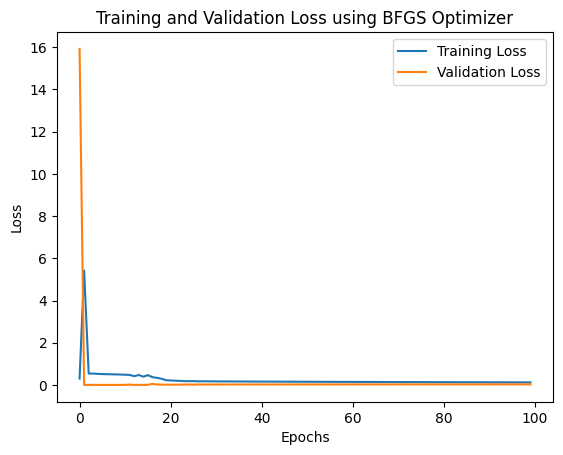

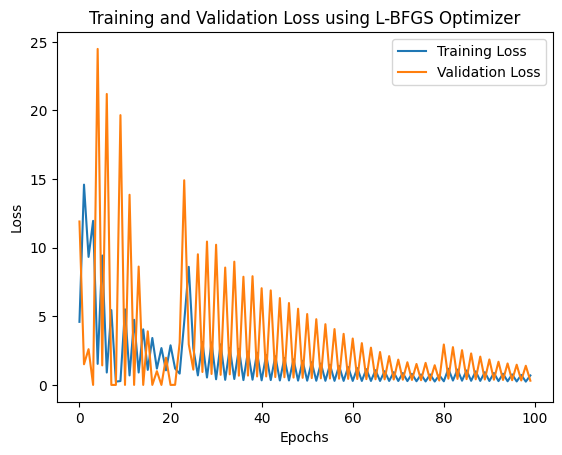

In [5]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Load dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# One hot encode the target
y = tf.keras.utils.to_categorical(y, 3)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),  # Input size is 4
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model with a dummy optimizer to initialize variables
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Prepare initial weights and biases
initial_weights = model.get_weights()

# Flatten initial weights to pass to the optimizer
def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])

initial_weights_flat = flatten_weights(initial_weights)

# Define a function to set weights from a flattened array
def set_weights_from_flat(weights_flat):
    weights = []
    index = 0
    for layer in model.layers:
        layer_weights = []
        for weight in layer.get_weights():
            weight_shape = weight.shape
            weight_size = np.prod(weight_shape)
            layer_weights.append(weights_flat[index:index+weight_size].reshape(weight_shape))
            index += weight_size
        weights.extend(layer_weights)
    return weights

# Define the loss function for optimization
def loss_fn(weights_flat):
    weights = set_weights_from_flat(weights_flat)
    model.set_weights(weights)
    loss_value = model.evaluate(X_train, y_train, verbose=0)[0]
    return loss_value

# Define the gradient function for optimization
def grad_fn(weights_flat):
    with tf.GradientTape() as tape:
        weights = set_weights_from_flat(weights_flat)
        model.set_weights(weights)
        y_pred = model(X_train, training=True)
        loss_value = tf.keras.losses.categorical_crossentropy(y_train, y_pred)
    grads = tape.gradient(loss_value, model.trainable_variables)
    grads_flat = flatten_weights([g.numpy() for g in grads])
    return grads_flat

# Optimize using BFGS
result_bfgs = minimize(loss_fn, initial_weights_flat, method='BFGS', jac=grad_fn, options={'maxiter': 100})
final_weights_bfgs = set_weights_from_flat(result_bfgs.x)

# Optimize using L-BFGS
result_lbfgs = minimize(loss_fn, initial_weights_flat, method='L-BFGS-B', jac=grad_fn, options={'maxiter': 100})
final_weights_lbfgs = set_weights_from_flat(result_lbfgs.x)

# Function to plot loss
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

# Train model using BFGS optimized weights
model.set_weights(final_weights_bfgs)
history_bfgs = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
plot_loss(history_bfgs, 'Training and Validation Loss using BFGS Optimizer')

# Train model using L-BFGS optimized weights
model.set_weights(final_weights_lbfgs)
history_lbfgs = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=0)
plot_loss(history_lbfgs, 'Training and Validation Loss using L-BFGS Optimizer')
